In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

前面调参只是一直在调K的值，但是KNN实际除了K这个参数还有距离度量方式这个参数，因此这里便来测试这个新的参数。

# 读取数据

In [2]:
dirPath = "data preprocessed\\unnormalized"

trainSet_origin = np.loadtxt(dirPath + '\\train.csv', delimiter=",")
validateSet_origin = np.loadtxt(dirPath + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath + '\\test.csv', delimiter=",")

trainSet_origin.shape, validateSet_origin.shape, testSet.shape

((33600, 18), (14400, 18), (12000, 17))

划分数据集特征和标签：

In [3]:
trainSet, trainSetLabel = trainSet_origin[:, :-1], trainSet_origin[:, -1]
validateSet, validateSetLabel = validateSet_origin[:, :-1], validateSet_origin[:, -1]
trainSet.shape, validateSet.shape

((33600, 17), (14400, 17))

# 实现评测指标

In [4]:
def calcF1(predictLabel, realLabel, printRes=False):
    '''给定算法得到的分类结果和实际的分类结果，计算评测指标
    注意：标签为1则为正标签，标签不为1则为负标签'''
    def safeDivide(a, b):
        '''子函数：当分母为0时返回除式结果为 -1'''
        return a/b if b != 0 else 0
    
    TP = Counter(np.logical_and(predictLabel==1, realLabel==1))[True]
    FN = Counter(np.logical_and(predictLabel!=1, realLabel==1))[True]
    FP = Counter(np.logical_and(predictLabel==1, realLabel!=1))[True]
    if(printRes):
        print("TP FN FP", TP, FN, FP)
    F1 = safeDivide(2*TP, 2*TP+FN+FP)
    return F1

print('test 1: normal one')
calcF1(arr([1, 1, 0, 0]), arr([1, 0, 1, 0]), True)
print('\ntest 2: may have zero division error')
calcF1(arr([0, 0, 1, 0]), arr([1, 0, 1, 0]), True)

test 1: normal one
TP FN FP 1 1 1


0.5


test 2: may have zero division error
TP FN FP 1 1 0


0.6666666666666666

# 距离度量方式

欧式距离之前测试过了，这里便测试下其他9种距离。

参考：https://www.cnblogs.com/heaad/archive/2011/03/08/1977733.html

In [5]:
class distanceMetric:
    
    def __init__(self, tag):
        self.tag = tag
        
    def Manhattan(self, dataSet, inputVector):
        '''曼哈顿距离'''
        diff = np.abs(dataSet - inputVector)
        distances = diff.sum(axis=1)
        return distances
    
    def Chebyshev(self, dataSet, inputVector):
        '''切比雪夫距离'''
        diff = np.abs(dataSet - inputVector)
        distances = np.max(diff, axis=1)
        return distances

    def Minkowski(self, dataSet, inputVector):
        '''闵可夫斯基距离:
        闵氏距离不是一种距离，而是一组距离的定义。
        
        其中p是一个变参数。

        当p=1时，就是曼哈顿距离

        当p=2时，就是欧氏距离

        当p→∞时，就是切比雪夫距离
        
        这里暂不实现'''
        pass    
    
    def StandardizedEuclidean(self, dataSet, inputVector):
        '''标准化欧氏距离:
        这个也测试过了，在这个project上不适用'''
        pass
    
    def Mahalanobis(self, dataSet, inputVector):
        '''马氏距离'''
        def SubMahalanobis(vec1, vec2):
            npvec = np.array([vec1, vec2])
            sub = npvec.T[0]-npvec.T[1]
            #print(np.cov(vec1, vec2))
            inv_sub = np.linalg.pinv(np.cov(vec1, vec2))
            return np.sqrt(np.dot(inv_sub, sub).dot(sub.T))  
        
        distances = np.zeros(dataSet.shape[0])
        for i in range(dataSet.shape[0]):
            distances[i] = SubMahalanobis(dataSet[i,:], inputVector)
        return distances
    
    def Cosine(self, dataSet, inputVector):
        '''夹角余弦'''
        a = np.dot(dataSet, inputVector.T)
        b = np.sqrt(np.sum(dataSet**2, axis=1))
        c = np.sqrt(np.sum(inputVector**2))
        distances = a/(b*c)
        return distances
    
    def Hamming(self, dataSet, inputVector):
        '''汉明距离:
        两个等长字符串s1与s2之间的汉明距离定义为将其中一个变为另外一个所需要作的最小替换次数。
        例如字符串“1111”与“1001”之间的汉明距离为2。
        这个在离散变量上可能有效果，但是在连续数据上直接应用怕是不行'''
        pass    
    
    def JaccardSimilarity(self, dataSet, inputVector):
        '''杰卡德相似系数：
        两个集合A和B的交集元素在A，B的并集中所占的比例，称为两个集合的杰卡德相似系数
        在此次project怕也是无法应用'''
        pass
    
    def Correlation(self, dataSet, inputVector):
        '''相关距离'''
        distances = np.zeros(dataSet.shape[0])
        for i in range(dataSet.shape[0]):
            distances[i] = 1 - np.corrcoef(np.vstack([dataSet[i,:], inputVector]))[0,1]
#         distances = 1 - np.corrcoef(np.vstack([dataSet, inputVector]))[]
        return distances
     
    def calcDistance(self, dataSet, inputVector):
        
        if self.tag == 1:
            return self.Manhattan(dataSet, inputVector)
        elif self.tag == 2:
            return self.Chebyshev(dataSet, inputVector)
        elif self.tag == 3:
            return self.Cosine(dataSet, inputVector)
        elif self.tag == 4:
            return self.Mahalanobis(dataSet, inputVector)
        else:
            return self.Correlation(dataSet, inputVector)

############### 函数测试 ##################                
# distanceMetric(1).calcDistance(arr([[1,1,0,0],
#                                     [0,1,1,1],
#                                     [1,0,0,1]]), arr([0,1,1,0]))

# distanceMetric(2).calcDistance(arr([[2,1,0,0],
#                                     [0,1,8,1],
#                                     [1,0,0,6]]), arr([0,1,1,0]))

# distanceMetric(4).calcDistance(arr([[2,1,0,0],
#                                     [0,1,8,1],
#                                     [1,0,0,6]]), arr([0,1,1,0]))
                    
# distanceMetric(3).calcDistance(arr([[2,1,0,0],
#                                     [0,1,8,1],
#                                     [1,0,0,6]]), arr([0,1,1,0]))

# distanceMetric(5).calcDistance(arr([[1,2,3,4]]), arr([3,8,7,6]))

# KNN

In [6]:
def knn_classify(dataSet, labels, k, inputVector, distanceMetricID):
    '''使用knn对输入的向量进行分类，使用距离加权'''
    dm = distanceMetric(distanceMetricID)
    distances = dm.calcDistance(dataSet, inputVector)
    #得到 K 个近邻的下标
    kNeighborsIndex  = distances.argpartition(k-1)[0:k]
    #计算 K 个近邻的距离倒数
    kDatas = 1/distances[kNeighborsIndex]
    #得到 对应的 K 个标签
    kLabels = labels[kNeighborsIndex]
    
    predictLabel = np.NAN
    maxDis = -np.inf
    for i in np.unique(kLabels):
        dis = np.sum(kDatas[kLabels==i]) 
        #print(dis)
        if dis > maxDis:
            maxDis = dis
            predictLabel = i
    #返回分类结果
    return predictLabel

##############测试程序#######################
knn_classify(arr([[1,1,0,0],
              [0,1,1,1],
              [1,0,0,1]]).copy(), arr([1, 0, 1]), 3, arr([0,1,1,0]), 2)
##############测试程序#######################

1

# 调参

所调参数只有K。

In [7]:
def run_knn_classify(dataSet, k, distanceId):
    ansLabel = []
    for i in tnrange(len(dataSet), leave=False):
        ansLabel.append(knn_classify(trainSet, trainSetLabel, k, dataSet[i], distanceId))
    return arr(ansLabel)

def getTestF1(k, distanceId):
    ansLabel = run_knn_classify(validateSet, k, distanceId)
    return calcF1(ansLabel, validateSetLabel)

In [18]:
idx_1 = [5]
idx_2 = [16]
a = 10
b = 3

trainSet[:, idx_1] *= a
validateSet[:, idx_1] *= a
# trainSet[:, idx_2] *= b
# validateSet[:, idx_2] *= b

getTestF1(1,1)

trainSet[:, idx_1] /= a
validateSet[:, idx_1] /= a
# trainSet[:, idx_2] /= b
# validateSet[:, idx_2] /= b

0.8460229689493832

```
feature   correlation    P-value
C0:     (-0.1367228801231376, 5.6128076980813327e-199)
C2:     (-0.010606971574000507, 0.020132146981624768)
C3:     (-0.020491007131788752, 7.13204838678767e-06)
C4:     (-0.018251452638581255, 6.3631684408671407e-05)
C5:     (0.060864948512591527, 1.2353251190166544e-40)
C6:     (0.033848102804751375, 1.1918967614351947e-13)
C7:     (-0.003857965644441051, 0.39798854401833916)
C8:     (0.0096253273294879434, 0.034962065531650773)
C9:     (0.14238764472723386, 8.4129813312857441e-216)
C10:     (0.048925696083644915, 7.7496877848978146e-27)
C11:     (0.050970941935891474, 5.4572580679401273e-29)
C12:     (-0.010848298342236428, 0.017465868226132608)
C13:     (1.0, 0.0)
```

In [8]:
def getTestF1_2(train, validate, k, distanceId):
    ansLabel = []
    for i in tnrange(len(validate), leave=False):
        ansLabel.append(knn_classify(train, trainSetLabel, k, validate[i], distanceId))
    return calcF1(arr(ansLabel), validateSetLabel)

In [9]:
for i in tnrange(trainSet.shape[1]):
    train = np.delete(trainSet, i, 1)
    validate = np.delete(validateSet, i, 1)
    print(i, getTestF1_2(train, validate, 1, 1))

0 0.8902005404636609
1 0.8901372395648155
2 0.8901372395648155
3 0.8902005404636609
4 0.8902005404636609
5 0.7710622710622711
6 0.8885413704862098
7 0.8704964539007092
8 0.8806479113384484
9 0.8137227105188546
10 0.8843992316995092
11 0.8834730709108995
12 0.8822901089510788
13 0.8206153187236777
14 0.8902005404636609
15 0.8902005404636609
16 0.8903749021839653



In [10]:
getTestF1(1, 2)

0.8602700781805259

In [11]:
getTestF1(1, 3)

0.6559446444434055

1-5:

测试了之后发现曼哈顿和切比雪夫的表现比较好。

所以尝试跑一下这两个距离的rank.

In [13]:
testRange = np.arange(1, 10)
testRange

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

## 测试曼哈顿距离

In [14]:
F1s_1 = []
for k in tnrange(1, len(testRange)+1):
    F1s_1.append(getTestF1(k, 1))

bestK_1 = testRange[np.argmax(F1s_1)]
bestK_1, np.max(F1s_1) 

(1, 0.89020054046366093)

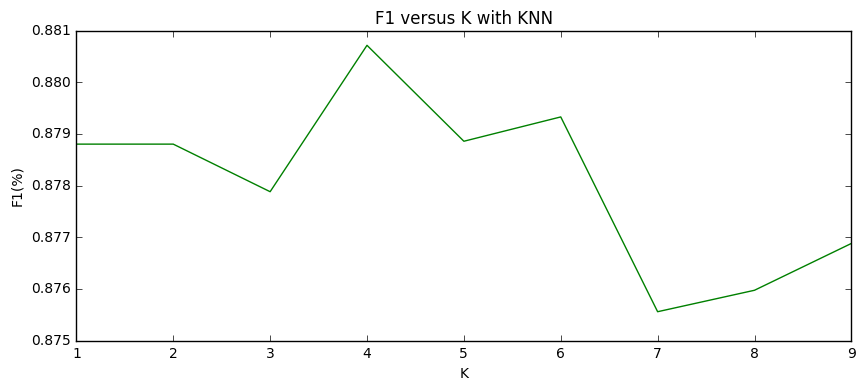

In [10]:
def show_fig():
    fig,ax = plt.subplots() 
    fig.set_size_inches(10, 4)
    plt.plot(testRange, F1s_1, 'g')
    plt.xlabel('K')
    plt.ylabel('F1(%)')
    plt.title("F1 versus K with KNN")
    plt.show()
    plt.close()
    
show_fig()

## 测试切比雪夫距离

In [15]:
F1s_2 = []
for k in tnrange(1, len(testRange)+1):
    F1s_2.append(getTestF1(k, 2))

bestK_2 = testRange[np.argmax(F1s_2)]
bestK_2, np.max(F1s_2) 

(1, 0.86027007818052592)

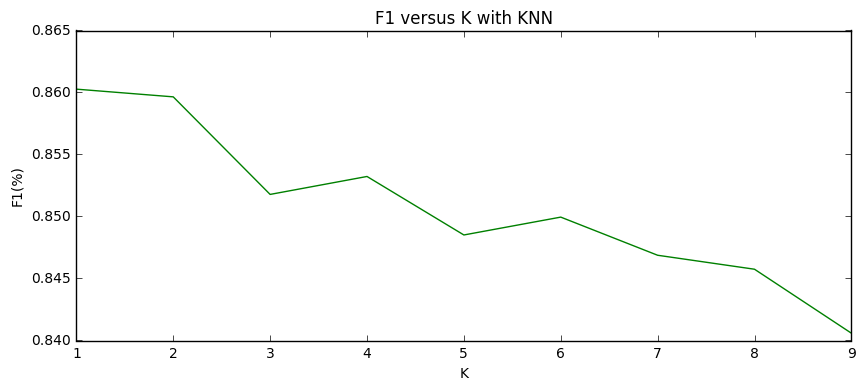

In [16]:
def show_fig():
    fig,ax = plt.subplots() 
    fig.set_size_inches(10, 4)
    plt.plot(testRange, F1s_2, 'g')
    plt.xlabel('K')
    plt.ylabel('F1(%)')
    plt.title("F1 versus K with KNN")
    plt.show()
    plt.close()
    
show_fig()

# 应用算法到测试集

In [11]:
# ansLabel = run_knn_classify(testSet, bestK)
# np.savetxt('.\\rank\\47_v2.csv', ansLabel, fmt="%d", delimiter="\n")